# Initial Set-up

In [ ]:
!nvidia-smi

Sat Dec 17 17:45:58 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    49W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:

!pip install -q python-levenshtein torchsummaryX wandb

     |████████████████████████████████| 1.9 MB 38.3 MB/s 
     |████████████████████████████████| 174 kB 62.6 MB/s 
     |████████████████████████████████| 2.2 MB 85.3 MB/s 
     |████████████████████████████████| 182 kB 95.6 MB/s 
     |████████████████████████████████| 173 kB 72.8 MB/s 
     |████████████████████████████████| 62 kB 1.7 MB/s 
     |████████████████████████████████| 168 kB 95.5 MB/s 
     |████████████████████████████████| 168 kB 103.5 MB/s 
     |████████████████████████████████| 166 kB 100.2 MB/s 
     |████████████████████████████████| 166 kB 103.0 MB/s 
     |████████████████████████████████| 162 kB 82.7 MB/s 
     |████████████████████████████████| 162 kB 101.8 MB/s 
     |████████████████████████████████| 158 kB 102.5 MB/s 
     |████████████████████████████████| 157 kB 98.1 MB/s 
     |████████████████████████████████| 157 kB 98.3 MB/s 
     |████████████████████████████████| 157 kB 101.0 MB/s 
     |████████████████████████████████| 157 kB 92.9 MB/s 
     |████

# Import

In [ ]:
import os
import pandas as pd
import numpy as np
import Levenshtein

import torch
import torchaudio
import random
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
import gc
from torchsummaryX import summary
import wandb
from glob import glob
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
import torchaudio.transforms as tat


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device: ", device)

device:  cuda


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Config

In [ ]:
# Global config dict. Feel free to add or change if you want.
config = {
    'batch_size': 128,
    'epochs': 80,
    'lr': 1e-3
}

# Kaggle Data

In [ ]:
# Download the data
!kaggle competitions download -c 11-785-f22-hw4p2
!mkdir '/content/data'

!unzip -qo '11-785-f22-hw4p2.zip' -d '/content/data'

100% 2.08G/2.09G [01:31<00:00, 25.3MB/s]
100% 2.09G/2.09G [01:31<00:00, 24.4MB/s]


# Dataset Class

In [ ]:
# These are the various characters in the transcripts of the datasetW
VOCAB = ['<sos>',   
         'A',   'B',    'C',    'D',    
         'E',   'F',    'G',    'H',    
         'I',   'J',    'K',    'L',       
         'M',   'N',    'O',    'P',    
         'Q',   'R',    'S',    'T', 
         'U',   'V',    'W',    'X', 
         'Y',   'Z',    "'",    ' ', 
         '<eos>']

VOCAB_MAP = {VOCAB[i]:i for i in range(0, len(VOCAB))}
VOCAB_MAP["<pad>"]  = len(VOCAB_MAP)
VOCAB               = list(VOCAB_MAP.keys())

SOS_TOKEN = VOCAB_MAP["<sos>"]
EOS_TOKEN = VOCAB_MAP["<eos>"]

In [ ]:
len(VOCAB)

31

In [ ]:
def convert_letter_to_index(letter):
  index = VOCAB.index(letter)
  return index


In [ ]:
class AudioDataset(torch.utils.data.Dataset):


    
    def __init__(self,data_path,transform = None,partition= "train", limit=-1): 
        '''
        Initializes the dataset.

        INPUTS: What inputs do you need here?
        '''
        # Load the directory and all files in them
        self.transform = transform
        self.data_path = data_path

        self.mfcc_dir =  ["/train-clean-100/mfcc" if partition == "train" else "/dev-clean/mfcc"][0]
        self.transcript_dir = ["/train-clean-100/transcript/raw" if partition == "train" else "/dev-clean/transcript/raw"][0]

        self.mfcc_files = sorted(os.listdir(self.data_path+self.mfcc_dir)) 
        self.transcript_files = sorted(os.listdir(self.data_path+self.transcript_dir))
        assert len(self.mfcc_files) == len(self.transcript_files) # Making sure that we have the same no. of mfcc and transcripts

        
        self.mfccs, self.transcripts = [], []
        # Iterate through mfccs and transcripts
        for i in range(0, len(self.mfcc_files)):
        #   Load a single mfcc
            mfcc = np.load(self.data_path+self.mfcc_dir+"/"+self.mfcc_files[i],allow_pickle=True)
            # mfcc = (mfcc - np.mean(mfcc, axis=0))/ np.std(mfcc, axis=0)
            mfcc -= (np.mean(mfcc, axis=0) + 1e-8)
       
        #   Load the corresponding transcript
            transcript = np.load(self.data_path+self.transcript_dir+"/"+self.transcript_files[i],allow_pickle=True)

            transcript = np.vectorize(convert_letter_to_index)(transcript)
        #   Append each mfcc to self.mfcc, transcript to self.transcript
            self.mfccs.append(mfcc)
            self.transcripts.append(transcript)
       
        self.length = len(self.mfccs)
        
     
          
    def __len__(self):
   
        return self.length

    def __getitem__(self, ind):

        mfcc = self.mfccs[ind]
        transcript = self.transcripts[ind]
     
        return mfcc, transcript, len(mfcc), len(transcript)


    def collate_fn(self,batch):

        # batch of input mfcc coefficients
        batch_mfcc = [torch.as_tensor(x) for x,_,_,_ in batch]
        mfcc_len = [l for _,_,l,_ in batch]
        

        # batch of output phonemes
        batch_transcript = [torch.as_tensor(y) for _,y,_,_ in batch]
        transcript_len = [l for _,_,_,l in batch]
        batch_mfcc_s = batch_mfcc
        
        lengths_mfcc = mfcc_len

        batch_transcript_s = batch_transcript
     
        lengths_transcript = transcript_len
       

        batch_mfcc_pad = pad_sequence(batch_mfcc_s,batch_first=True, padding_value=EOS_TOKEN)
        batch_transcript_pad = pad_sequence(batch_transcript_s,batch_first=True, padding_value=EOS_TOKEN)

        #if self.transform:
        #  for trans in self.transform:
        #    batch_mfcc_pad = trans(batch_mfcc_pad)
        if self.transform != None:
            batch_mfcc_pad = self.transform(batch_mfcc_pad)


        # Return the following values: padded features, padded labels, actual length of features, actual length of the labels
        return batch_mfcc_pad, batch_transcript_pad, torch.tensor(lengths_mfcc), torch.tensor(lengths_transcript)

       

In [ ]:
# Test Dataloader

class AudioDatasetTest(torch.utils.data.Dataset):

    def __init__(self,data_path, limit=-1): 
        '''
        Initializes the dataset.

        INPUTS: What inputs do you need here?
        '''

        # Load the directory and all files in them
        self.data_path = data_path

        self.mfcc_dir =  ["/test-clean/mfcc"][0]
        self.mfcc_files = sorted(os.listdir(self.data_path+self.mfcc_dir)) 
        self.mfccs= []

        
        # Iterate through mfccs and transcripts
        for i in range(0, len(self.mfcc_files)):
        #   Load a single mfcc
            mfcc = np.load(self.data_path+self.mfcc_dir+"/"+self.mfcc_files[i],allow_pickle=True)
            mfcc -= (np.mean(mfcc, axis=0) + 1e-8)
            # mfcc = (mfcc - np.mean(mfcc, axis=0)) / np.std(mfcc, axis=0)
            self.mfccs.append(mfcc)

       

    def __len__(self):
        
        '''
    
        '''
        return len(self.mfccs)

    def __getitem__(self, ind):

        
        mfcc = self.mfccs[ind]
        mfcc_length = len(mfcc)
        
        return mfcc,mfcc_length

    def collate_fn(self,batch):
     
        # batch of input mfcc coefficients
        batch_mfcc = [torch.as_tensor(x) for x,_ in batch]
        mfcc_len = [l for _,l in batch]

        batch_mfcc_pad = pad_sequence(batch_mfcc,batch_first=True, padding_value=EOS_TOKEN)
        

        return batch_mfcc_pad,  torch.tensor(mfcc_len)


In [ ]:
# Create objects for the dataset class
root = '/content/data/hw4p2' 
transforms = torch.nn.Sequential(tat.FrequencyMasking(freq_mask_param=6))
train_data = AudioDataset(data_path=root,partition= "train",transform = None) 
val_data =  AudioDataset(data_path=root,partition= "dev")
test_data = AudioDatasetTest(data_path=root)


train_loader = torch.utils.data.DataLoader(train_data, num_workers= 4,
                                           batch_size=config['batch_size'], pin_memory= True,
                                           shuffle= True, collate_fn = train_data.collate_fn)

val_loader = torch.utils.data.DataLoader(val_data, num_workers= 4,
                                         batch_size=config['batch_size'], pin_memory= True,
                                         shuffle= False, collate_fn = val_data.collate_fn)

test_loader = torch.utils.data.DataLoader(test_data, num_workers= 4, 
                                          batch_size=config['batch_size'], pin_memory= True, 
                                          shuffle= False, collate_fn = test_data.collate_fn)


print("Batch size: ", config['batch_size'])
print("Train dataset samples = {}, batches = {}".format(train_data.__len__(), len(train_loader)))
print("Val dataset samples = {}, batches = {}".format(val_data.__len__(), len(val_loader)))
print("Test dataset samples = {}, batches = {}".format(test_data.__len__(), len(test_loader)))

Batch size:  128
Train dataset samples = 28539, batches = 223
Val dataset samples = 2703, batches = 22
Test dataset samples = 2620, batches = 21


In [ ]:
# sanity check
for data in train_loader:
    x, y, lx, ly = data
    print(x.shape, y.shape, lx.shape, ly.shape)
    break   

torch.Size([128, 1680, 15]) torch.Size([128, 329]) torch.Size([128]) torch.Size([128])


# Model

set-ups

In [ ]:
class LockedDropout(torch.nn.Module):
  #refer to pytorchnlp
  def __init__(self, p=0.5):
        self.p = p
        super().__init__()
  
  def forward(self,x):
    if not self.training or not self.p:
      return x
      
    
    new_x = x
    mask = x.new_empty(x.size(0), 1, x.size(2), requires_grad=False).bernoulli_(1 - self.p)
    mask = mask.div_(1 - self.p)
    mask = mask.expand_as(new_x)
    return new_x * mask

In this section you will be building the LAS model from scratch. Before starting to code, please read the writeup, paper and understand the following parts completely.<br>
- Pyramidal Bi-LSTM 
- Listener
- Attention
- Speller

After getting a good grasp of the workings of these modules, start coding. Follow the #s carefully. We will also be adding some extra features to the attention mechanism like keys and values which are not originally present in LAS. So we will be creating a hybrid network based on LAS and Attention is All You Need.


## Encoder

### Pyramidal Bi-LSTM

In [ ]:
class pBLSTM(torch.nn.Module):

    
    def __init__(self, input_size, hidden_size):
        super(pBLSTM, self).__init__()

        self.blstm = torch.nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=2, bidirectional=True, batch_first=True)

    def forward(self, x_packed): # x_packed is a PackedSequence


        x, x_lens = pad_packed_sequence(x_packed, batch_first=True)
        batch_size, seq_len, input_len = x.shape
        new_x,new_x_lens = self.trunc_reshape(x,x_lens)
        packed = pack_padded_sequence(new_x, new_x_lens, enforce_sorted=False, batch_first=True)

        out,_ = self.blstm(packed)

        return out

    def trunc_reshape(self, x, x_lens): 
      
        batch_size, seq_len, input_len = x.shape
        if seq_len %2 ==0:
          x = x.reshape([batch_size,seq_len//2, input_len*2])
        else:
          x = x[:, :-1, :].reshape([batch_size, seq_len // 2, input_len * 2])

        x_lens //=2

        return x, x_lens

### Listener

In [ ]:
class Listener(torch.nn.Module):
    '''
    The Encoder takes utterances as inputs and returns latent feature representations
    '''
    def __init__(self, input_size, encoder_hidden_size):
        super(Listener, self).__init__()

        # The first LSTM at the very bottom
        self.base_lstm = torch.nn.LSTM(input_size=input_size, hidden_size=encoder_hidden_size, num_layers=2, bidirectional=True, batch_first=True)##: Fill this up

        
        self.pblstm1 = pBLSTM(encoder_hidden_size*4,encoder_hidden_size)
            
        self.dropout = LockedDropout(p=0.4)
        self.regularDrop = torch.nn.Dropout(p = 0.35)
        self.pblstm2=pBLSTM(encoder_hidden_size*4,encoder_hidden_size)
        self.pblstm3=pBLSTM(encoder_hidden_size*4,encoder_hidden_size)
            
         
    def forward(self, x, x_lens):
        
        # #: Pack Padded Sequence
        packed = pack_padded_sequence(x, x_lens, enforce_sorted=False, batch_first=True)
        # #: Pass it through the first LSTM layer (no truncation)
        out1, hidden1 = self.base_lstm(packed)
        
      
        # #: Pass Sequence through the pyramidal Bi-LSTM layer
        out2 = self.pblstm1(out1)
        pad1,lens1 = pad_packed_sequence(out2,batch_first=True)
        drop1 = self.dropout(pad1)
        packed1 = pack_padded_sequence(drop1, lens1, enforce_sorted=False, batch_first=True)
        
        out3 = self.pblstm1(packed1)
        pad2,lens2 = pad_packed_sequence(out3,batch_first=True)
        drop2 = self.dropout(pad2)
        packed2 = pack_padded_sequence(drop2, lens2, enforce_sorted=False, batch_first=True)

        out4 = self.pblstm1(packed2)
        pad3,encoder_lens = pad_packed_sequence(out4,batch_first=True)
        encoder_outputs = self.dropout(pad3)
 

        return encoder_outputs, encoder_lens

## Attention (Attend)

### Different ways to compute Attention

1. Dot-product attention
    * raw_weights = bmm(key, query) 
    * Optional: Scaled dot-product by normalizing with sqrt key dimension 
    * Check "Attention is All You Need" Section 3.2.1
    * 1st way is what most TAs are comfortable with, but if you want to explore, check out other methods below


2. Cosine attention
    * raw_weights = cosine(query, key) # almost the same as dot-product xD 

3. Bi-linear attention
    * W = Linear transformation (learnable parameter): d_k -> d_q
    * raw_weights = bmm(key @ W, query)

4. Multi-layer perceptron
    * Check "Neural Machine Translation and Sequence-to-sequence Models: A Tutorial" Section 8.4

5. Multi-Head Attention
    * Check "Attention is All You Need" Section 3.2.2
    * h = Number of heads
    * W_Q, W_K, W_V: Weight matrix for Q, K, V (h of them in total)
    * W_O: d_v -> d_v
    * Reshape K: (B, T, d_k) to (B, T, h, d_k // h) and transpose to (B, h, T, d_k // h)
    * Reshape V: (B, T, d_v) to (B, T, h, d_v // h) and transpose to (B, h, T, d_v // h)
    * Reshape Q: (B, d_q) to (B, h, d_q // h) `
    * raw_weights = Q @ K^T
    * masked_raw_weights = mask(raw_weights)
    * attention = softmax(masked_raw_weights)
    * multi_head = attention @ V
    * multi_head = multi_head reshaped to (B, d_v)
    * context = multi_head @ W_O

In [ ]:
def plot_attention(attention): 
    # Function for plotting attention
    plt.clf()
    sns.heatmap(attention, cmap='GnBu')
    plt.show()

class Attention(torch.nn.Module):

    def __init__(self, encoder_hidden_size, decoder_output_size, projection_size):
        super(Attention, self).__init__()

        self.key_projection     = torch.nn.Linear(in_features=encoder_hidden_size, out_features=projection_size, bias = False)
        # #: Define an nn.Linear layer which projects the encoder_hidden_state to keys
        self.value_projection   = torch.nn.Linear(in_features = encoder_hidden_size,out_features=projection_size,bias = False)
        # #: Define an nn.Linear layer which projects the encoder_hidden_state to value
        self.query_projection   = torch.nn.Linear(in_features = decoder_output_size,out_features=projection_size)
        # #: Define an nn.Linear layer which projects the decoder_output_state to query
        
        self.softmax            = torch.nn.Softmax(dim = 1) # #: Define a softmax layer. Think about the dimension which you need to apply 

    def set_key_value_mask(self, encoder_outputs, encoder_lens):
    
        _, encoder_max_seq_len, _ = encoder_outputs.shape

        self.key      = self.key_projection(encoder_outputs)
        self.value    = self.value_projection(encoder_outputs)

       
        # The mask is False for all indicies before padding begins, True for all indices after.
        lens = torch.arange(encoder_max_seq_len).unsqueeze(0)
        self.padding_mask     =  (lens>= encoder_lens.unsqueeze(1)).to(device) 
    def forward(self, decoder_output_embedding):
        # key   : (batch_size, timesteps, projection_size)
        # value : (batch_size, timesteps, projection_size)
        # query : (batch_size, projection_size)

        self.query         = self.query_projection(decoder_output_embedding)


        raw_weights        = (torch.bmm(self.key, self.query.unsqueeze(2))).squeeze(2)
        masked_raw_weights = raw_weights.masked_fill_(self.padding_mask, -float('inf')) 

        attention_weights  = self.softmax(raw_weights/np.sqrt(self.key.shape[2]))
        # #: Calculate the attention weights, which is the softmax of raw_weights
        context            = torch.bmm(attention_weights.unsqueeze(1), self.value).squeeze(1)
         # #: Calculate the context - it is a product between attention_weights and value

        return context, attention_weights # Return the context, attention_weights

## Decoder

### Speller

In [ ]:
class Speller(torch.nn.Module):

    def __init__(self, embed_size, decoder_hidden_size, decoder_output_size, vocab_size, attention_module= None):
        super().__init__()

        self.vocab_size         = vocab_size
        self.projection_size = 128

        self.embedding          =  torch.nn.Embedding(num_embeddings=self.vocab_size, embedding_dim=embed_size, padding_idx=EOS_TOKEN)
          
        self.lstm_cells         = torch.nn.Sequential(
                                torch.nn.LSTMCell(input_size=embed_size + decoder_output_size, hidden_size=decoder_hidden_size),
                                #torch.nn.Dropout(p = 0.35),
                                torch.nn.LSTMCell(input_size=decoder_hidden_size, hidden_size=decoder_hidden_size),
                                #torch.nn.Dropout(p = 0.35),
                                torch.nn.LSTMCell(input_size=decoder_hidden_size, hidden_size=decoder_output_size),

                                )
    
                   
        
        """
        self.lstm_cell1 = torch.nn.LSTMCell(input_size=embed_size + decoder_output_size, hidden_size=decoder_hidden_size)
        self.dropout = torch.nn.Dropout(p = 0.35)
        self.lstm_cell2 = torch.nn.LSTMCell(input_size=decoder_hidden_size, hidden_size=decoder_hidden_size)
        self.lstm_cell3 = torch.nn.LSTMCell(input_size=decoder_hidden_size, hidden_size=decoder_output_size)
        """


        self.char_prob          = torch.nn.Linear(in_features=embed_size, out_features=self.vocab_size)
        # #: Initialize the classification layer to generate your probability distribution over all characters

        self.char_prob.weight   = self.embedding.weight # Weight tying

        self.attention          = attention_module

    
    def forward(self, encoder_outputs, encoder_lens, y = None, tf_rate = 1): 

        '''
        Args: 
            embedding: Attention embeddings 
            hidden_list: List of Hidden States for the LSTM Cells
        ''' 

        batch_size, encoder_max_seq_len, _ = encoder_outputs.shape
        

        if self.training and y is not None:
            timesteps     = y.shape[1] # The number of timesteps is the sequence of length of your transcript during training
            label_embed   = self.embedding(y) # Embeddings of the transcript, when we want to use teacher forcing
        else:
            timesteps     = 600 
        

        # INITS
        predictions     = []

        # Initialize the first character input to your decoder, SOS
        char            = torch.full((batch_size,), fill_value=SOS_TOKEN, dtype= torch.long).to(device) 

        # Initialize a list to keep track of LSTM Cell Hidden and Cell Memory States, to None
        hidden_states   = [None]*3

        attention_plot          = []
        context                 = torch.zeros(batch_size, self.projection_size).to(device)
        #context = self.attention.value[:,0]
        predict                 = torch.zeros(batch_size, 1).to(device)
       
        attention_weights       = torch.zeros(batch_size, encoder_max_seq_len).to(device) 
        if self.attention != None:
            self.attention.set_key_value_mask(encoder_outputs, encoder_lens)


        for t in range(timesteps):
            char_embed = self.embedding(char)
            #if t == 0:
            #  char_embed = self.embedding(torch.zeros(batch_size).long().fill_(SOS_TOKEN).to(device))
              ##: Generate the embedding for the character at timestep t

            if self.training and t > 0: 
              if random.random()<tf_rate:
                char_embed = label_embed[:, t]
            
            decoder_input_embedding = torch.cat([char_embed,context],dim = 1)
            
           
            
            for i in range(len(self.lstm_cells)):
                # The second LSTM Cell takes in the output hidden state of the first LSTM Cell (from the current timestep) as Input, along with the hidden and cell states of the cell from the previous timestep
                hidden_states[i] = self.lstm_cells[i](decoder_input_embedding, hidden_states[i]) 
                decoder_input_embedding = hidden_states[i][0]
            
            """
            (h,c) = self.lstm_cell1(decoder_input_embedding, hidden_states[0])
            h = self.dropout(h)
            hidden_states[0] = (h,c)
            decoder_input_embedding = hidden_states[0][0]

            (h,c) = self.lstm_cell2(decoder_input_embedding, hidden_states[1])
            h = self.dropout(h)
            hidden_states[1] = (h,c)
            decoder_input_embedding = hidden_states[1][0]

            (h,c) = self.lstm_cell3(decoder_input_embedding, hidden_states[2])
            h = self.dropout(h)
            hidden_states[2] = (h,c)
            """

            # The output embedding from the decoder is the hidden state of the last LSTM Cell
            decoder_output_embedding = hidden_states[-1][0]

            # We compute attention from the output of the last LSTM Cell
            if self.attention != None:
                context, attention_weights = self.attention(decoder_output_embedding) # The returned query is the projected query

            attention_plot.append(attention_weights[0].detach().cpu())

            output_embedding     = torch.cat((self.attention.query, context), dim = 1)
            # #: Concatenate the projected query with context for the output embedding
      

            char_prob            = self.char_prob(output_embedding)
            
            # Append the character probability distribution to the list of predictions 
            predictions.append(char_prob)

            #char = # #: Get the predicted character for the next timestep from the probability distribution 
            char = torch.argmax(char_prob, dim = 1)
            
        attention_plot  = torch.stack(attention_plot,dim = 1)
        predictions     = torch.stack(predictions, dim = 1)

        return predictions, attention_plot

## Sequence-to-Sequence Model

In [ ]:
len(VOCAB_MAP)

31

In [ ]:
encoder_config = {
    'input_size' : 15,
    'encoder_hidden_size' : 512
}
decoder_config = {
    'decoder_output_size' : 128,
    'vocab_size': 31,
    'embed_size': 256,
    'projection_size': 128,
    'decoder_hidden_size':512
}

### LAS

In [ ]:
class LAS(torch.nn.Module):
    def __init__(self, input_size, encoder_hidden_size, 
                 vocab_size, embed_size,
                 decoder_hidden_size, decoder_output_size,
                 projection_size= 128):
        
        super(LAS, self).__init__()

        self.encoder        = Listener(input_size = input_size, encoder_hidden_size= encoder_hidden_size)
        attention_module    = Attention(encoder_hidden_size = encoder_hidden_size*2, decoder_output_size=decoder_output_size, projection_size=projection_size)
        self.decoder        = Speller(embed_size =embed_size, decoder_hidden_size = decoder_hidden_size, decoder_output_size = decoder_output_size, vocab_size = vocab_size, attention_module= attention_module) 

    def forward(self, x, x_lens, y = None, tf_rate = 1):

        encoder_outputs, encoder_lens = self.encoder(x, x_lens) # from Listener
        predictions, attention_plot = self.decoder(encoder_outputs, encoder_lens, y, tf_rate)
        
        return predictions, attention_plot

# Training Setup

## Model Setup










In [ ]:

model = LAS(
    input_size=encoder_config['input_size'], 
    encoder_hidden_size=encoder_config['encoder_hidden_size'], 
    vocab_size=decoder_config['vocab_size'], 
    embed_size = decoder_config['embed_size'],
    decoder_hidden_size=decoder_config['decoder_hidden_size'], 
    decoder_output_size=decoder_config['decoder_output_size'],
    projection_size= 128
  
)

model = model.to(device)
print(model)

summary(model, 
        x= x.to(device),
        x_lens = lx,
        y = y.to(device))

LAS(
  (encoder): Listener(
    (base_lstm): LSTM(15, 512, num_layers=2, batch_first=True, bidirectional=True)
    (pblstm1): pBLSTM(
      (blstm): LSTM(2048, 512, num_layers=2, batch_first=True, bidirectional=True)
    )
    (dropout): LockedDropout()
    (regularDrop): Dropout(p=0.35, inplace=False)
    (pblstm2): pBLSTM(
      (blstm): LSTM(2048, 512, num_layers=2, batch_first=True, bidirectional=True)
    )
    (pblstm3): pBLSTM(
      (blstm): LSTM(2048, 512, num_layers=2, batch_first=True, bidirectional=True)
    )
  )
  (decoder): Speller(
    (embedding): Embedding(31, 256, padding_idx=29)
    (lstm_cells): Sequential(
      (0): LSTMCell(384, 512)
      (1): LSTMCell(512, 512)
      (2): LSTMCell(512, 128)
    )
    (char_prob): Linear(in_features=256, out_features=31, bias=True)
    (attention): Attention(
      (key_projection): Linear(in_features=1024, out_features=128, bias=False)
      (value_projection): Linear(in_features=1024, out_features=128, bias=False)
      (quer

/usr/local/lib/python3.8/dist-packages/torchsummaryX/torchsummaryX.py:101: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_sum = df.sum()


                                               Kernel Shape      Output Shape  \
Layer                                                                           
0_encoder.LSTM_base_lstm                                  -    [162098, 1024]   
1_encoder.pblstm1.LSTM_blstm                              -     [81019, 1024]   
2_encoder.LockedDropout_dropout                           -  [128, 844, 1024]   
3_encoder.pblstm1.LSTM_blstm                              -     [40476, 1024]   
4_encoder.LockedDropout_dropout                           -  [128, 422, 1024]   
...                                                     ...               ...   
2028_decoder.lstm_cells.LSTMCell_1                        -        [128, 512]   
2029_decoder.lstm_cells.LSTMCell_2                        -        [128, 128]   
2030_decoder.attention.Linear_query_projection   [128, 128]        [128, 128]   
2031_decoder.attention.Softmax_softmax                    -        [128, 211]   
2032_decoder.Linear_char_pro

Kernel Shape      Output Shape  \
Layer                                                                           
0_encoder.LSTM_base_lstm                                  -    [162098, 1024]   
1_encoder.pblstm1.LSTM_blstm                              -     [81019, 1024]   
2_encoder.LockedDropout_dropout                           -  [128, 844, 1024]   
3_encoder.pblstm1.LSTM_blstm                              -     [40476, 1024]   
4_encoder.LockedDropout_dropout                           -  [128, 422, 1024]   
...                                                     ...               ...   
2028_decoder.lstm_cells.LSTMCell_1                        -        [128, 512]   
2029_decoder.lstm_cells.LSTMCell_2                        -        [128, 128]   
2030_decoder.attention.Linear_query_projection   [128, 128]        [128, 128]   
2031_decoder.attention.Softmax_softmax                    -        [128, 211]   
2032_decoder.Linear_char_prob                     [256, 31]         [128, 31]   

                                                    Params   Mult-Adds  
Layer                                                                   
0_encoder.LSTM_base_lstm                         8466432.0   8450048.0  
1_encoder.pblstm1.LSTM_blstm                    16793600.0  16777216.0  
2_encoder.LockedDropout_dropout                        NaN         NaN  
3_encoder.pblstm1.LSTM_blstm                           NaN  16777216.0  
4_encoder.LockedDropout_dropout                        NaN         NaN  
...                                                    ...         ...  
2028_decoder.lstm_cells.LSTMCell_1                     NaN   2097152.0  
2029_decoder.lstm_cells.LSTMCell_2                     NaN    327680.0  
2030_decoder.attention.Linear_query_projection         NaN     16384.0  
2031_decoder.attention.Softmax_softmax                 NaN         NaN  
2032_decoder.Linear_char_prob                          NaN      7936.0  

[2033 rows x 4 columns]

## Optimizer, Scheduler, Loss

In [ ]:
optimizer   = torch.optim.Adam(model.parameters(), lr= config['lr'], amsgrad= True, weight_decay= 5e-6)
criterion   = torch.nn.CrossEntropyLoss(reduction='none')
scaler      = torch.cuda.amp.GradScaler()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.3, verbose=True)



# Levenshtein Distance

In [ ]:

def indices_to_chars(indices, vocab):
    tokens = []
    for i in indices: # This loops through all the indices
        if int(i) == SOS_TOKEN: # If SOS is encountered, dont add it to the final list
            continue
        elif int(i) == EOS_TOKEN: # If EOS is encountered, stop the decoding process
            break
        else:
            tokens.append(vocab[int(i)])
    return tokens


def calc_edit_distance(predictions, y, ly, vocab= VOCAB, print_example= False):

    dist                = 0
    batch_size, seq_len = predictions.shape

    for batch_idx in range(batch_size): 

        y_sliced    = indices_to_chars(y[batch_idx,0:ly[batch_idx]], vocab)
        pred_sliced = indices_to_chars(predictions[batch_idx], vocab)

        # Strings - When you are using characters from the AudioDataset
        y_string    = ''.join(y_sliced)
        pred_string = ''.join(pred_sliced)
        
        dist        += Levenshtein.distance(pred_string, y_string)
     

    if print_example: 
       
        print("Ground Truth : ", y_string)
        print("Prediction   : ", pred_string)
        
    dist/=batch_size
    return dist

# Train and Evaluate

In [ ]:
def train(model, dataloader, criterion, optimizer, teacher_forcing_rate):

    model.train()
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc='Train')

    running_loss        = 0.0
    running_perplexity  = 0.0
    
    for i, (x, y, lx, ly) in enumerate(dataloader):

        optimizer.zero_grad()

        x, y, lx, ly = x.to(device), y.to(device), lx, ly

        with torch.cuda.amp.autocast():

            predictions, attention_plot = model(x, lx, y= y, tf_rate= teacher_forcing_rate)

            loss        =  criterion(predictions[:, :-1, :].reshape(-1, len(VOCAB_MAP)), y[:, 1:].reshape(-1))# #: Cross Entropy Loss

            mask        = (torch.arange(y.shape[1] - 1).unsqueeze(0) < ly.unsqueeze(1)).to(device)
            # #: Create a boolean mask using the lengths of your transcript that remove the influence of padding indices (in transcripts) in the loss 
            masked_loss = (loss * mask.reshape(-1)).sum() / mask.sum()
            # Product between the mask and the loss, divided by the mask's sum. Hint: You may want to reshape the mask too 
            perplexity  = torch.exp(masked_loss) # Perplexity is defined the exponential of the loss

            running_loss        += masked_loss.item()
            running_perplexity  += perplexity.item()
        
        # Backward on the masked loss
        scaler.scale(masked_loss).backward()

        
        scaler.step(optimizer)
        scaler.update()
        

        batch_bar.set_postfix(
            loss="{:.04f}".format(running_loss/(i+1)),
            perplexity="{:.04f}".format(running_perplexity/(i+1)),
            lr="{:.04f}".format(float(optimizer.param_groups[0]['lr'])),
            tf_rate='{:.02f}'.format(teacher_forcing_rate))
        batch_bar.update()

        del x, y, lx, ly
        torch.cuda.empty_cache()

    running_loss /= len(dataloader)
    running_perplexity /= len(dataloader)
    batch_bar.close()

    return running_loss, running_perplexity, attention_plot

In [ ]:
def validate(model, dataloader):

    model.eval()

    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc="Val")

    running_lev_dist = 0.0

    for i, (x, y, lx, ly) in enumerate(dataloader):

        x, y, lx, ly = x.to(device), y.to(device), lx, ly

        with torch.inference_mode():
            predictions, attentions = model(x, lx, y = None)

        # Greedy Decoding
        greedy_predictions   =  torch.argmax(predictions, dim = 2)
        # Calculate Levenshtein Distance
        running_lev_dist    += calc_edit_distance(greedy_predictions, y, ly, VOCAB, print_example = False) 

        batch_bar.set_postfix(
            dist="{:.04f}".format(running_lev_dist/(i+1)))
        batch_bar.update()

        del x, y, lx, ly
        torch.cuda.empty_cache()

    batch_bar.close()
    running_lev_dist /= len(dataloader)

    return running_lev_dist#, running_loss, running_perplexity, 

# Wandb

In [ ]:
!pip install wandb -q
import wandb

In [ ]:

wandb.login(key="xx")
run = wandb.init(
    name = "xx", 
    entity = "xx",
    reinit = True, ### Allows reinitalizing runs when you re-run this cell
    #run_id = "2jh3q5az",# Insert specific run id here if you want to resume a previous run
    #resume = "allow", ### You need this to resume previous runs, but comment out reinit = True when using this
    project = "xx", ### Project should be created in your wandb account 
    config = config ### Wandb Config for your run
)


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


In [ ]:
checkpoint = torch.load('/content/gdrive/MyDrive/11785/checkpoint1.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
best_lev_dist = checkpoint['val_dist']
#erset lr
optimizer.param_groups[0]['lr'] = 1e-2




In [ ]:
weights_file = wandb.restore('/content/gdrive/MyDrive/11785/checkpoint1.pth')
model.load_state_dict(torch.load(weights_file.name)['model_state_dict'])

<All keys matched successfully>

# Experiments

Train:   0%|          | 0/223 [00:00<?, ?it/s]


Epoch 1/80: 
 Train Loss 1.9366	  Learning Rate 0.0010


Val:   0%|          | 0/22 [00:00<?, ?it/s]

Val Dist 527.1866


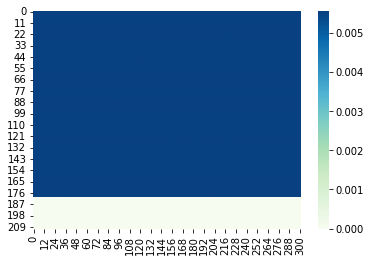

Saving model


Train:   0%|          | 0/223 [00:00<?, ?it/s]


Epoch 2/80: 
 Train Loss 1.3480	  Learning Rate 0.0010


Val:   0%|          | 0/22 [00:00<?, ?it/s]

Val Dist 535.9547


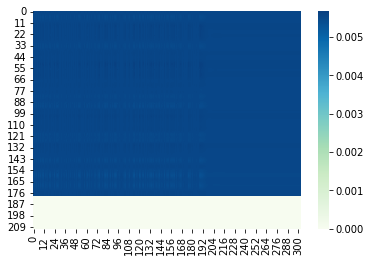

Saving model


Train:   0%|          | 0/223 [00:00<?, ?it/s]


Epoch 3/80: 
 Train Loss 1.2588	  Learning Rate 0.0010


Val:   0%|          | 0/22 [00:00<?, ?it/s]

Val Dist 534.2184


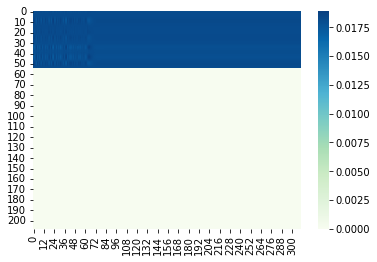

Saving model


Train:   0%|          | 0/223 [00:00<?, ?it/s]


Epoch 4/80: 
 Train Loss 1.2149	  Learning Rate 0.0010


Val:   0%|          | 0/22 [00:00<?, ?it/s]

Val Dist 528.0073


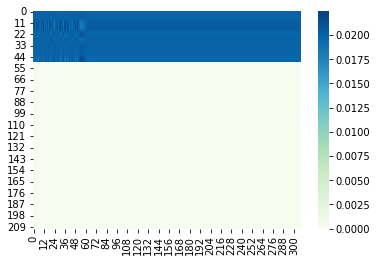

Saving model


Train:   0%|          | 0/223 [00:00<?, ?it/s]


Epoch 5/80: 
 Train Loss 1.1829	  Learning Rate 0.0010


Val:   0%|          | 0/22 [00:00<?, ?it/s]

Val Dist 531.3246


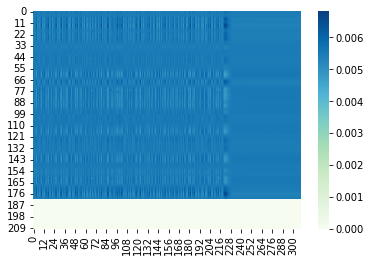

Saving model


Train:   0%|          | 0/223 [00:00<?, ?it/s]


Epoch 6/80: 
 Train Loss 1.1587	  Learning Rate 0.0010


Val:   0%|          | 0/22 [00:00<?, ?it/s]

Val Dist 528.4405


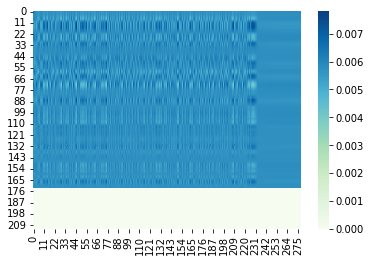

Saving model


Train:   0%|          | 0/223 [00:00<?, ?it/s]


Epoch 7/80: 
 Train Loss 1.1382	  Learning Rate 0.0010


Val:   0%|          | 0/22 [00:00<?, ?it/s]

Val Dist 527.7902


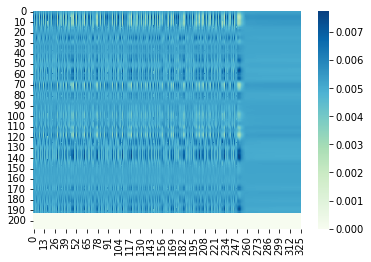

Saving model


Train:   0%|          | 0/223 [00:00<?, ?it/s]


Epoch 8/80: 
 Train Loss 1.1199	  Learning Rate 0.0010


Val:   0%|          | 0/22 [00:00<?, ?it/s]

Val Dist 525.4843


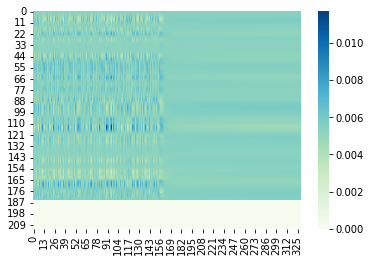

Saving model


Train:   0%|          | 0/223 [00:00<?, ?it/s]


Epoch 9/80: 
 Train Loss 1.1036	  Learning Rate 0.0010


Val:   0%|          | 0/22 [00:00<?, ?it/s]

Val Dist 526.0107


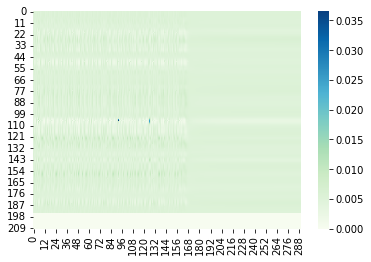

Saving model


Train:   0%|          | 0/223 [00:00<?, ?it/s]


Epoch 10/80: 
 Train Loss 1.0873	  Learning Rate 0.0010


Val:   0%|          | 0/22 [00:00<?, ?it/s]

Val Dist 526.1600


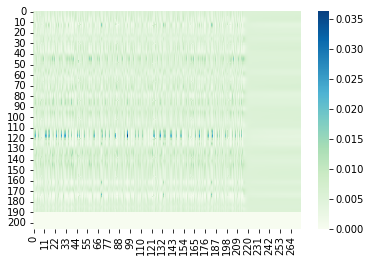

Saving model


Train:   0%|          | 0/223 [00:00<?, ?it/s]


Epoch 11/80: 
 Train Loss 1.0716	  Learning Rate 0.0010


Val:   0%|          | 0/22 [00:00<?, ?it/s]

Val Dist 524.1103


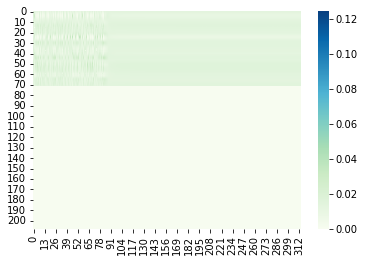

Saving model


Train:   0%|          | 0/223 [00:00<?, ?it/s]


Epoch 12/80: 
 Train Loss 1.0552	  Learning Rate 0.0010


Val:   0%|          | 0/22 [00:00<?, ?it/s]

Val Dist 522.7765


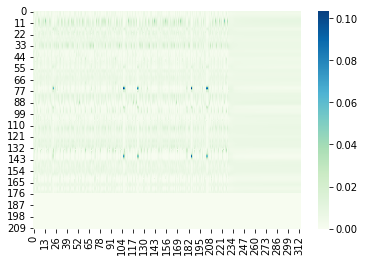

Saving model


Train:   0%|          | 0/223 [00:00<?, ?it/s]


Epoch 13/80: 
 Train Loss 1.0371	  Learning Rate 0.0010


Val:   0%|          | 0/22 [00:00<?, ?it/s]

Val Dist 525.5910


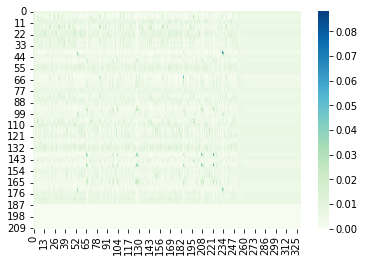

Saving model


Train:   0%|          | 0/223 [00:00<?, ?it/s]


Epoch 14/80: 
 Train Loss 1.0112	  Learning Rate 0.0010


Val:   0%|          | 0/22 [00:00<?, ?it/s]

Val Dist 520.9437


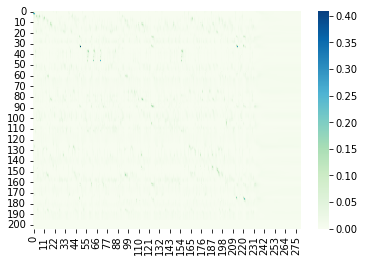

Saving model


Train:   0%|          | 0/223 [00:00<?, ?it/s]


Epoch 15/80: 
 Train Loss 0.9149	  Learning Rate 0.0010


Val:   0%|          | 0/22 [00:00<?, ?it/s]

Val Dist 451.4150


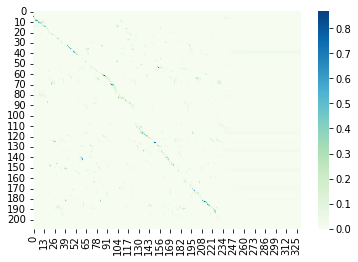

Saving model


Train:   0%|          | 0/223 [00:00<?, ?it/s]


Epoch 16/80: 
 Train Loss 0.5249	  Learning Rate 0.0010


Val:   0%|          | 0/22 [00:00<?, ?it/s]

Val Dist 92.2819


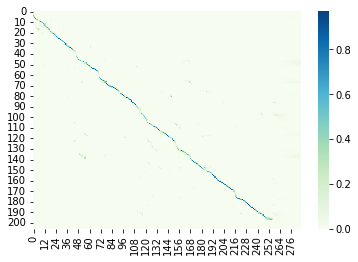

Saving model


Train:   0%|          | 0/223 [00:00<?, ?it/s]


Epoch 17/80: 
 Train Loss 0.2969	  Learning Rate 0.0010


Val:   0%|          | 0/22 [00:00<?, ?it/s]

Val Dist 54.0353


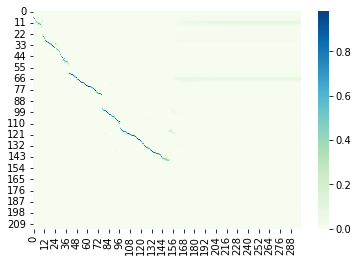

Saving model


Train:   0%|          | 0/223 [00:00<?, ?it/s]


Epoch 18/80: 
 Train Loss 0.2160	  Learning Rate 0.0010


Val:   0%|          | 0/22 [00:00<?, ?it/s]

Val Dist 42.9703


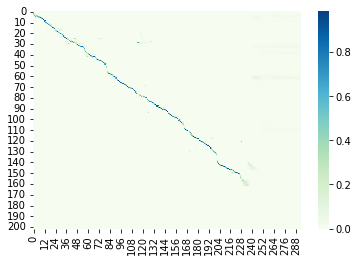

Saving model


Train:   0%|          | 0/223 [00:00<?, ?it/s]


Epoch 19/80: 
 Train Loss 0.1704	  Learning Rate 0.0010


Val:   0%|          | 0/22 [00:00<?, ?it/s]

Val Dist 36.3406


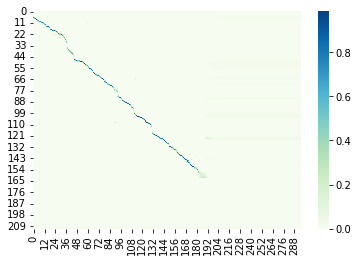

Saving model


Train:   0%|          | 0/223 [00:00<?, ?it/s]


Epoch 20/80: 
 Train Loss 0.1516	  Learning Rate 0.0010


Val:   0%|          | 0/22 [00:00<?, ?it/s]

Val Dist 35.2133


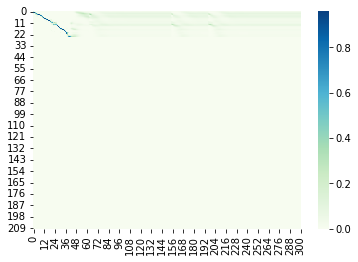

Saving model


Train:   0%|          | 0/223 [00:00<?, ?it/s]


Epoch 21/80: 
 Train Loss 0.1360	  Learning Rate 0.0010


Val:   0%|          | 0/22 [00:00<?, ?it/s]

Val Dist 34.7283


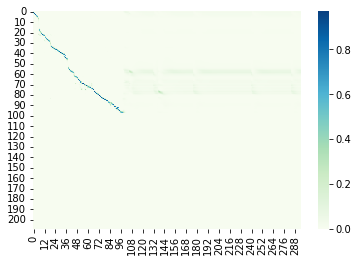

Saving model


Train:   0%|          | 0/223 [00:00<?, ?it/s]


Epoch 22/80: 
 Train Loss 0.1235	  Learning Rate 0.0010


Val:   0%|          | 0/22 [00:00<?, ?it/s]

Val Dist 30.5603


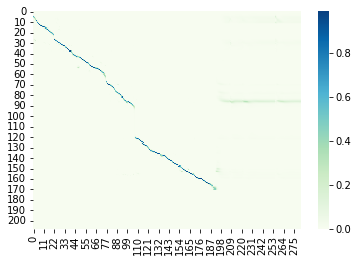

Saving model


Train:   0%|          | 0/223 [00:00<?, ?it/s]


Epoch 23/80: 
 Train Loss 0.1160	  Learning Rate 0.0010


Val:   0%|          | 0/22 [00:00<?, ?it/s]

Val Dist 27.1459


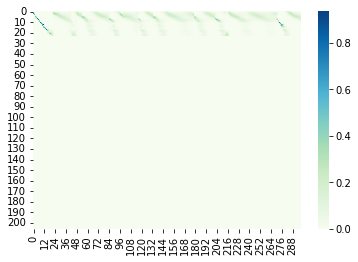

Saving model


Train:   0%|          | 0/223 [00:00<?, ?it/s]


Epoch 24/80: 
 Train Loss 0.1100	  Learning Rate 0.0010


Val:   0%|          | 0/22 [00:00<?, ?it/s]

Val Dist 25.5101


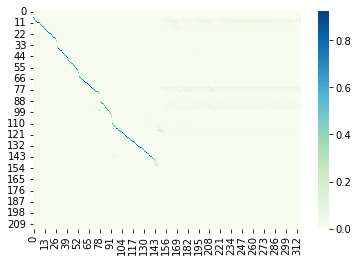

Saving model


Train:   0%|          | 0/223 [00:00<?, ?it/s]


Epoch 25/80: 
 Train Loss 0.1022	  Learning Rate 0.0010


Val:   0%|          | 0/22 [00:00<?, ?it/s]

Val Dist 25.0029


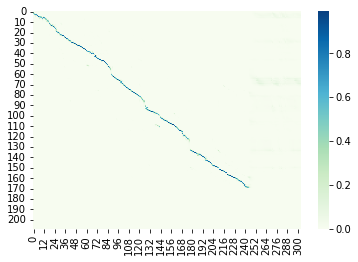

Saving model


Train:   0%|          | 0/223 [00:00<?, ?it/s]


Epoch 26/80: 
 Train Loss 0.1004	  Learning Rate 0.0010


Val:   0%|          | 0/22 [00:00<?, ?it/s]

Val Dist 23.7227


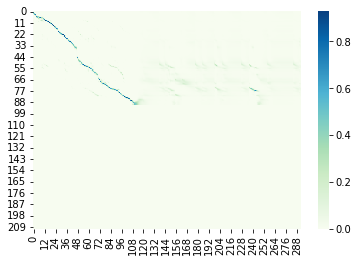

Saving model


Train:   0%|          | 0/223 [00:00<?, ?it/s]


Epoch 27/80: 
 Train Loss 0.0916	  Learning Rate 0.0010


Val:   0%|          | 0/22 [00:00<?, ?it/s]

Val Dist 23.5063


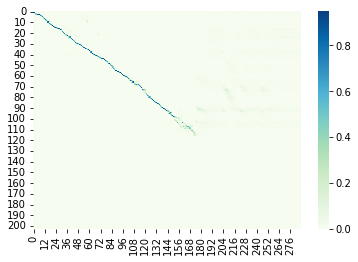

Saving model


Train:   0%|          | 0/223 [00:00<?, ?it/s]


Epoch 28/80: 
 Train Loss 0.0895	  Learning Rate 0.0010


Val:   0%|          | 0/22 [00:00<?, ?it/s]

Val Dist 24.0615


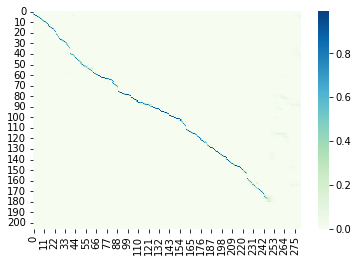

Saving model


Train:   0%|          | 0/223 [00:00<?, ?it/s]


Epoch 29/80: 
 Train Loss 0.0879	  Learning Rate 0.0010


Val:   0%|          | 0/22 [00:00<?, ?it/s]

Val Dist 22.9159


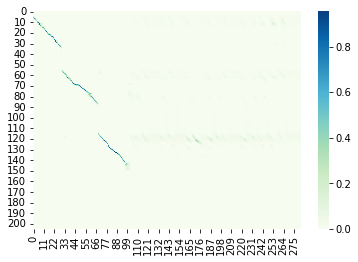

Saving model


Train:   0%|          | 0/223 [00:00<?, ?it/s]


Epoch 30/80: 
 Train Loss 0.0854	  Learning Rate 0.0010


Val:   0%|          | 0/22 [00:00<?, ?it/s]

Val Dist 22.8356


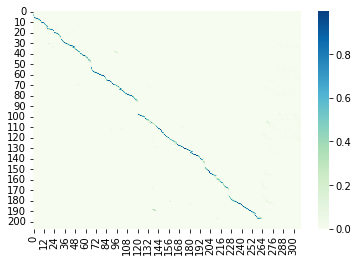

Saving model


Train:   0%|          | 0/223 [00:00<?, ?it/s]


Epoch 31/80: 
 Train Loss 0.0843	  Learning Rate 0.0010


Val:   0%|          | 0/22 [00:00<?, ?it/s]

Val Dist 21.5814


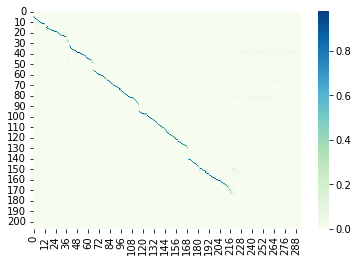

Saving model


Train:   0%|          | 0/223 [00:00<?, ?it/s]


Epoch 32/80: 
 Train Loss 0.0821	  Learning Rate 0.0010


Val:   0%|          | 0/22 [00:00<?, ?it/s]

Val Dist 20.5875


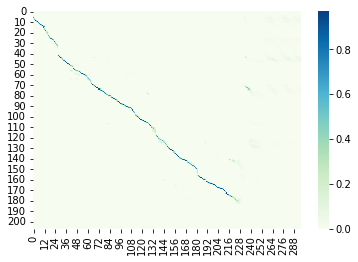

Saving model


Train:   0%|          | 0/223 [00:00<?, ?it/s]


Epoch 33/80: 
 Train Loss 0.0789	  Learning Rate 0.0010


Val:   0%|          | 0/22 [00:00<?, ?it/s]

Val Dist 20.7124


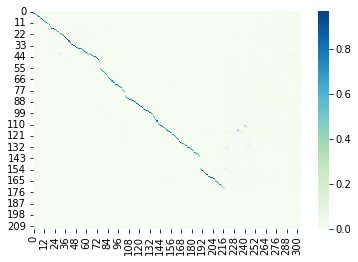

Saving model


Train:   0%|          | 0/223 [00:00<?, ?it/s]


Epoch 34/80: 
 Train Loss 0.0802	  Learning Rate 0.0010


Val:   0%|          | 0/22 [00:00<?, ?it/s]

Val Dist 21.0915


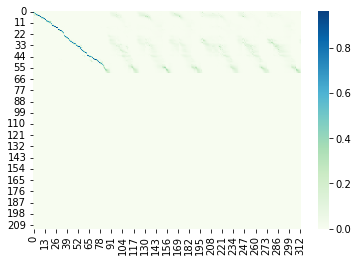

Saving model


Train:   0%|          | 0/223 [00:00<?, ?it/s]


Epoch 35/80: 
 Train Loss 0.0790	  Learning Rate 0.0010


Val:   0%|          | 0/22 [00:00<?, ?it/s]

Val Dist 20.2088


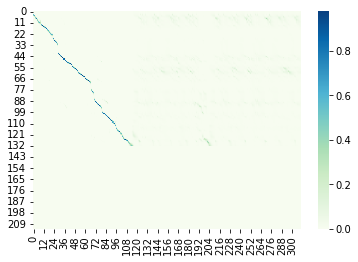

Saving model


Train:   0%|          | 0/223 [00:00<?, ?it/s]


Epoch 36/80: 
 Train Loss 0.0781	  Learning Rate 0.0010


Val:   0%|          | 0/22 [00:00<?, ?it/s]

Val Dist 20.4757


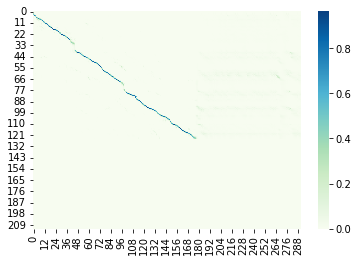

Saving model


Train:   0%|          | 0/223 [00:00<?, ?it/s]


Epoch 37/80: 
 Train Loss 0.0778	  Learning Rate 0.0010


Val:   0%|          | 0/22 [00:00<?, ?it/s]

Val Dist 19.3065


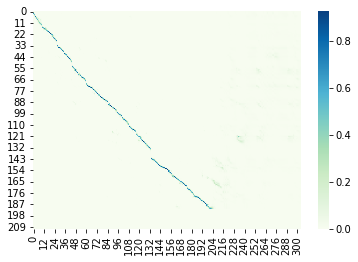

Saving model


Train:   0%|          | 0/223 [00:00<?, ?it/s]


Epoch 38/80: 
 Train Loss 0.0770	  Learning Rate 0.0010


Val:   0%|          | 0/22 [00:00<?, ?it/s]

Val Dist 20.0360


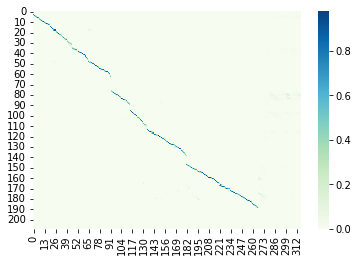

Saving model


Train:   0%|          | 0/223 [00:00<?, ?it/s]


Epoch 39/80: 
 Train Loss 0.0791	  Learning Rate 0.0010


Val:   0%|          | 0/22 [00:00<?, ?it/s]

Val Dist 18.4647


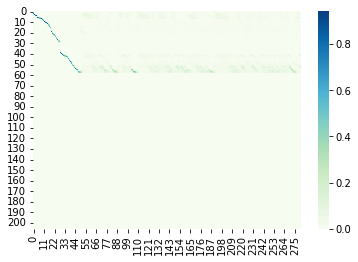

Saving model


Train:   0%|          | 0/223 [00:00<?, ?it/s]


Epoch 40/80: 
 Train Loss 0.0810	  Learning Rate 0.0010


Val:   0%|          | 0/22 [00:00<?, ?it/s]

Val Dist 19.5746


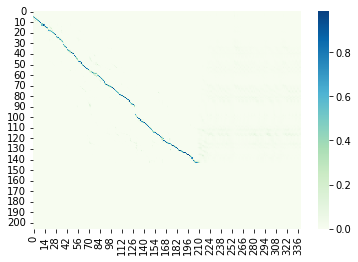

Saving model


Train:   0%|          | 0/223 [00:00<?, ?it/s]


Epoch 41/80: 
 Train Loss 0.0776	  Learning Rate 0.0010


Val:   0%|          | 0/22 [00:00<?, ?it/s]

Val Dist 19.0474


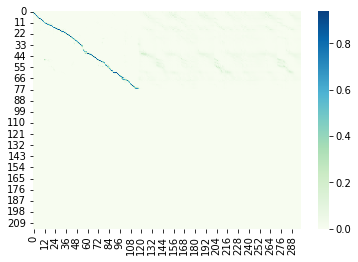

Saving model


Train:   0%|          | 0/223 [00:00<?, ?it/s]


Epoch 42/80: 
 Train Loss 0.0781	  Learning Rate 0.0010


Val:   0%|          | 0/22 [00:00<?, ?it/s]

Val Dist 19.9526


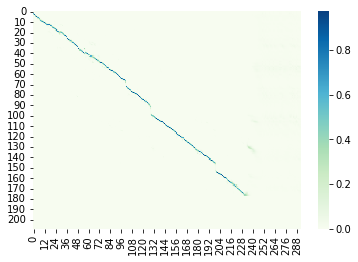

Saving model


Train:   0%|          | 0/223 [00:00<?, ?it/s]


Epoch 43/80: 
 Train Loss 0.0766	  Learning Rate 0.0010


Val:   0%|          | 0/22 [00:00<?, ?it/s]

Val Dist 18.9923


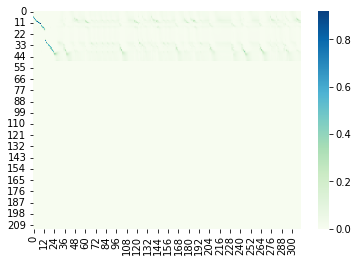

Epoch 00025: reducing learning rate of group 0 to 3.0000e-04.
Saving model


Train:   0%|          | 0/223 [00:00<?, ?it/s]


Epoch 44/80: 
 Train Loss 0.0369	  Learning Rate 0.0003


Val:   0%|          | 0/22 [00:00<?, ?it/s]

Val Dist 16.0544


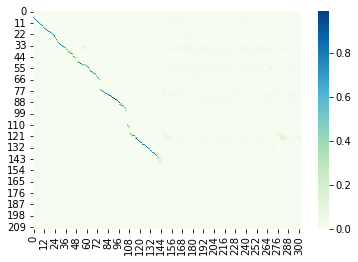

Saving model


Train:   0%|          | 0/223 [00:00<?, ?it/s]


Epoch 45/80: 
 Train Loss 0.0193	  Learning Rate 0.0003


Val:   0%|          | 0/22 [00:00<?, ?it/s]

Val Dist 15.7800


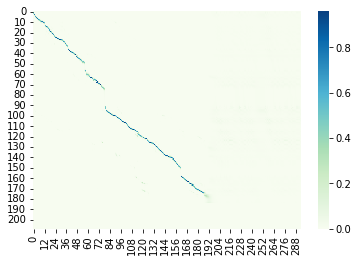

Saving model


Train:   0%|          | 0/223 [00:00<?, ?it/s]


Epoch 46/80: 
 Train Loss 0.0148	  Learning Rate 0.0003


Val:   0%|          | 0/22 [00:00<?, ?it/s]

Val Dist 15.9802


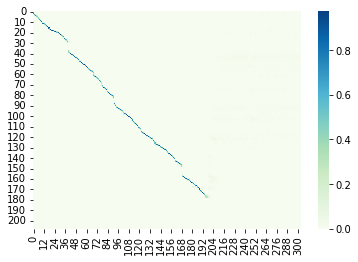

Saving model


Train:   0%|          | 0/223 [00:00<?, ?it/s]


Epoch 47/80: 
 Train Loss 0.0130	  Learning Rate 0.0003


Val:   0%|          | 0/22 [00:00<?, ?it/s]

Val Dist 16.8199


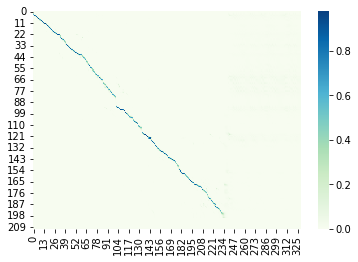

Saving model


Train:   0%|          | 0/223 [00:00<?, ?it/s]


Epoch 48/80: 
 Train Loss 0.0114	  Learning Rate 0.0003


Val:   0%|          | 0/22 [00:00<?, ?it/s]

Val Dist 16.3201


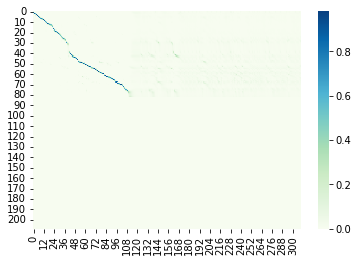

Saving model


Train:   0%|          | 0/223 [00:00<?, ?it/s]


Epoch 49/80: 
 Train Loss 0.0103	  Learning Rate 0.0003


Val:   0%|          | 0/22 [00:00<?, ?it/s]

Val Dist 16.1770


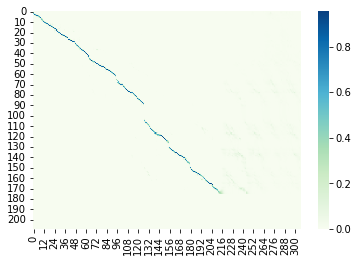

Epoch 00031: reducing learning rate of group 0 to 9.0000e-05.
Saving model


Train:   0%|          | 0/223 [00:00<?, ?it/s]


Epoch 50/80: 
 Train Loss 0.0089	  Learning Rate 0.0001


Val:   0%|          | 0/22 [00:00<?, ?it/s]

Val Dist 15.9416


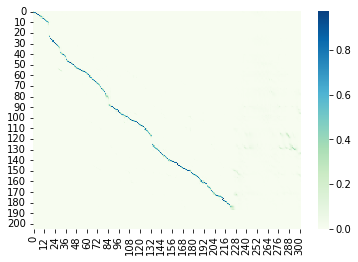

Saving model


Train:   0%|          | 0/223 [00:00<?, ?it/s]


Epoch 51/80: 
 Train Loss 0.0078	  Learning Rate 0.0001


Val:   0%|          | 0/22 [00:00<?, ?it/s]

Val Dist 16.0551


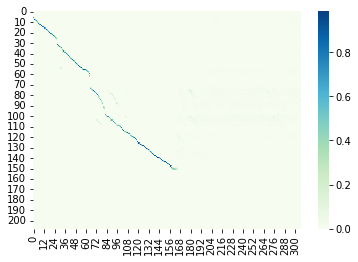

Saving model


Train:   0%|          | 0/223 [00:00<?, ?it/s]


Epoch 52/80: 
 Train Loss 0.0083	  Learning Rate 0.0001


Val:   0%|          | 0/22 [00:00<?, ?it/s]

Val Dist 15.8424


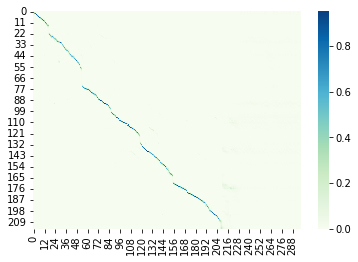

Saving model


Train:   0%|          | 0/223 [00:00<?, ?it/s]


Epoch 53/80: 
 Train Loss 0.0075	  Learning Rate 0.0001


Val:   0%|          | 0/22 [00:00<?, ?it/s]

Val Dist 16.4247


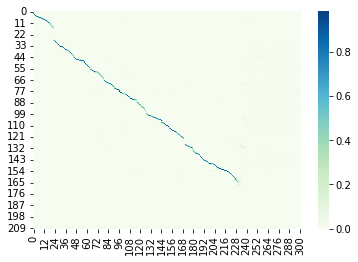

Epoch 00035: reducing learning rate of group 0 to 2.7000e-05.
Saving model


Train:   0%|          | 0/223 [00:00<?, ?it/s]


Epoch 54/80: 
 Train Loss 0.0073	  Learning Rate 0.0000


Val:   0%|          | 0/22 [00:00<?, ?it/s]

Val Dist 15.7022


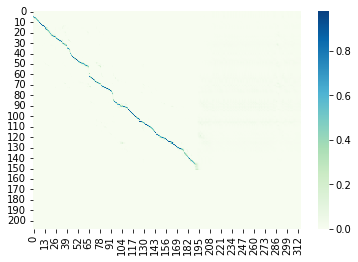

Saving model


Train:   0%|          | 0/223 [00:00<?, ?it/s]


Epoch 55/80: 
 Train Loss 0.0068	  Learning Rate 0.0000


Val:   0%|          | 0/22 [00:00<?, ?it/s]

Val Dist 16.1118


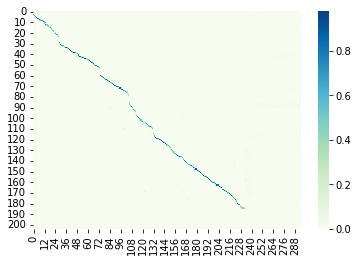

Saving model


Train:   0%|          | 0/223 [00:00<?, ?it/s]


Epoch 56/80: 
 Train Loss 0.0076	  Learning Rate 0.0000


Val:   0%|          | 0/22 [00:00<?, ?it/s]

Val Dist 16.0676


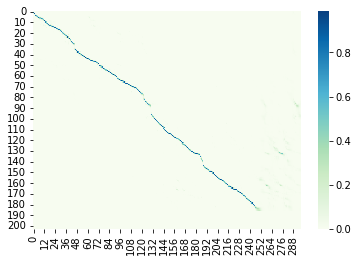

Saving model


Train:   0%|          | 0/223 [00:00<?, ?it/s]


Epoch 57/80: 
 Train Loss 0.0070	  Learning Rate 0.0000


Val:   0%|          | 0/22 [00:00<?, ?it/s]

Val Dist 15.0872


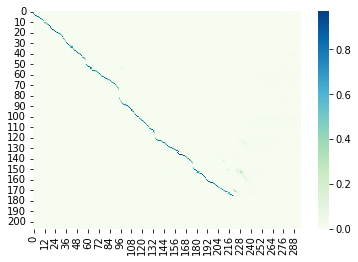

Saving model


Train:   0%|          | 0/223 [00:00<?, ?it/s]


Epoch 58/80: 
 Train Loss 0.0076	  Learning Rate 0.0000


Val:   0%|          | 0/22 [00:00<?, ?it/s]

Val Dist 15.1716


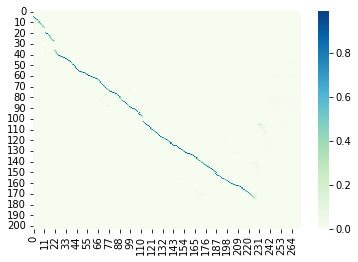

Saving model


Train:   0%|          | 0/223 [00:00<?, ?it/s]


Epoch 59/80: 
 Train Loss 0.0076	  Learning Rate 0.0000


Val:   0%|          | 0/22 [00:00<?, ?it/s]

Val Dist 15.9166


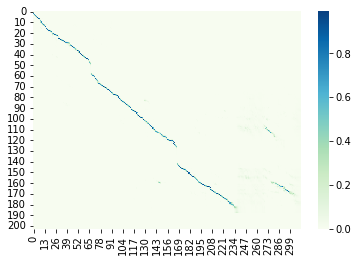

Saving model


Train:   0%|          | 0/223 [00:00<?, ?it/s]


Epoch 60/80: 
 Train Loss 0.0074	  Learning Rate 0.0000


Val:   0%|          | 0/22 [00:00<?, ?it/s]

Val Dist 16.0335


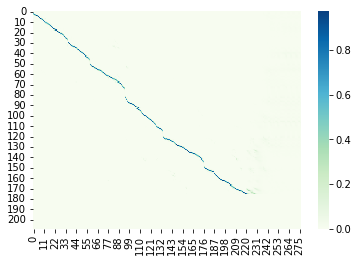

Saving model


Train:   0%|          | 0/223 [00:00<?, ?it/s]


Epoch 61/80: 
 Train Loss 0.0074	  Learning Rate 0.0000


Val:   0%|          | 0/22 [00:00<?, ?it/s]

Val Dist 15.9894


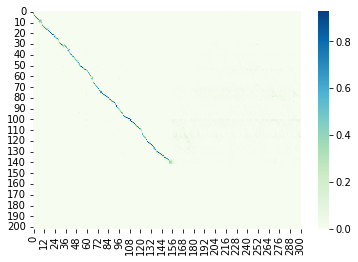

Epoch 00043: reducing learning rate of group 0 to 8.1000e-06.
Saving model


Train:   0%|          | 0/223 [00:00<?, ?it/s]


Epoch 62/80: 
 Train Loss 0.0077	  Learning Rate 0.0000


Val:   0%|          | 0/22 [00:00<?, ?it/s]

Val Dist 15.9698


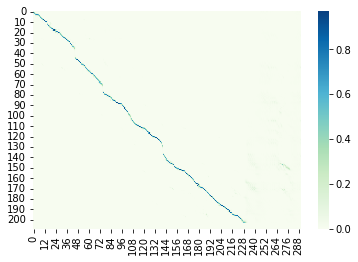

Saving model


Train:   0%|          | 0/223 [00:00<?, ?it/s]


Epoch 63/80: 
 Train Loss 0.0082	  Learning Rate 0.0000


Val:   0%|          | 0/22 [00:00<?, ?it/s]

Val Dist 16.1711


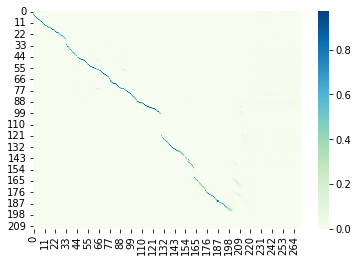

Saving model


Train:   0%|          | 0/223 [00:00<?, ?it/s]


Epoch 64/80: 
 Train Loss 0.0077	  Learning Rate 0.0000


Val:   0%|          | 0/22 [00:00<?, ?it/s]

Val Dist 16.1091


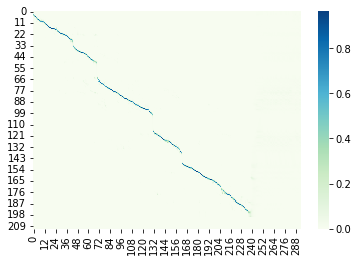

Saving model


Train:   0%|          | 0/223 [00:00<?, ?it/s]


Epoch 65/80: 
 Train Loss 0.0086	  Learning Rate 0.0000


Val:   0%|          | 0/22 [00:00<?, ?it/s]

Val Dist 15.4455


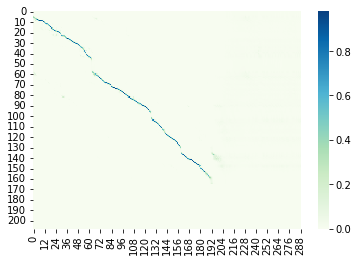

Epoch 00047: reducing learning rate of group 0 to 2.4300e-06.
Saving model


Train:   0%|          | 0/223 [00:00<?, ?it/s]


Epoch 66/80: 
 Train Loss 0.0085	  Learning Rate 0.0000


Val:   0%|          | 0/22 [00:00<?, ?it/s]

Val Dist 15.7126


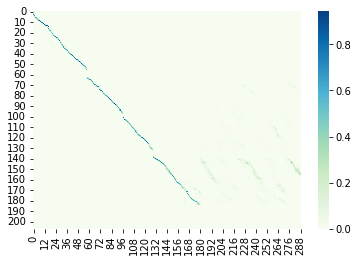

Saving model


Train:   0%|          | 0/223 [00:00<?, ?it/s]


Epoch 67/80: 
 Train Loss 0.0087	  Learning Rate 0.0000


Val:   0%|          | 0/22 [00:00<?, ?it/s]

Val Dist 15.7846


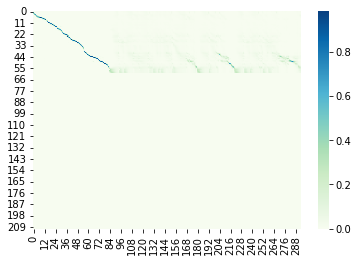

Saving model


Train:   0%|          | 0/223 [00:00<?, ?it/s]


Epoch 68/80: 
 Train Loss 0.0089	  Learning Rate 0.0000


Val:   0%|          | 0/22 [00:00<?, ?it/s]

Val Dist 15.7828


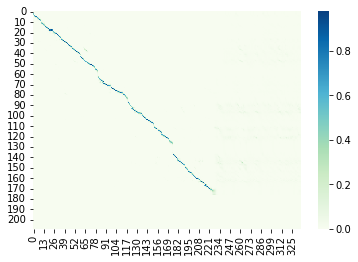

Saving model


Train:   0%|          | 0/223 [00:00<?, ?it/s]


Epoch 69/80: 
 Train Loss 0.0100	  Learning Rate 0.0000


Val:   0%|          | 0/22 [00:00<?, ?it/s]

Val Dist 16.3147


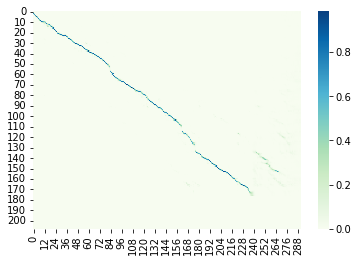

Epoch 00051: reducing learning rate of group 0 to 7.2900e-07.
Saving model


Train:   0%|          | 0/223 [00:00<?, ?it/s]


Epoch 70/80: 
 Train Loss 0.0086	  Learning Rate 0.0000


Val:   0%|          | 0/22 [00:00<?, ?it/s]

Val Dist 16.2719


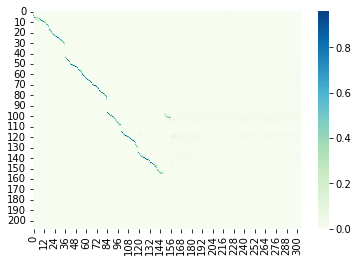

Saving model


Train:   0%|          | 0/223 [00:00<?, ?it/s]


Epoch 71/80: 
 Train Loss 0.0097	  Learning Rate 0.0000


Val:   0%|          | 0/22 [00:00<?, ?it/s]

Val Dist 16.2222


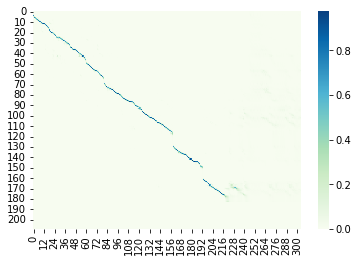

Saving model


Train:   0%|          | 0/223 [00:00<?, ?it/s]


Epoch 72/80: 
 Train Loss 0.0103	  Learning Rate 0.0000


Val:   0%|          | 0/22 [00:00<?, ?it/s]

Val Dist 16.2398


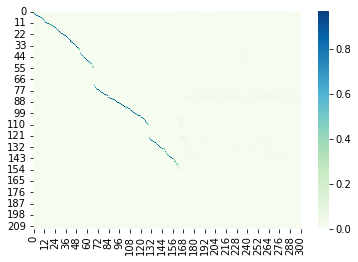

Saving model


Train:   0%|          | 0/223 [00:00<?, ?it/s]


Epoch 73/80: 
 Train Loss 0.0098	  Learning Rate 0.0000


Val:   0%|          | 0/22 [00:00<?, ?it/s]

Val Dist 16.4545


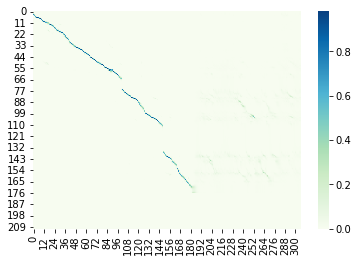

Epoch 00055: reducing learning rate of group 0 to 2.1870e-07.
Saving model


Train:   0%|          | 0/223 [00:00<?, ?it/s]

In [ ]:
best_lev_dist = float("inf")
tf_rate = 1

for epoch in range(0, config['epochs']):
    

    # Call train and validate 
    
    curr_lr = float(optimizer.param_groups[0]['lr'])
    train_loss, train_perplexity, attention_plot = train(model, dataloader=train_loader, criterion=criterion, optimizer= optimizer, teacher_forcing_rate = tf_rate)

    print("\nEpoch {}/{}: \n Train Loss {:.04f}\t  Learning Rate {:.04f}".format(
        epoch + 1,
        config['epochs'],
        train_loss,
        curr_lr
        ))


    val_lev_dist = validate(model, val_loader)
    print("Val Dist {:.04f}".format(val_lev_dist))
    
    plot_attention(attention_plot)

    # Log metrics to Wandb
    wandb.log({"train_loss":train_loss, 'validation_distance':val_lev_dist,
              "learning_Rate": curr_lr})

    if val_lev_dist <40:
      tf_rate *= 0.985
      scheduler.step(val_lev_dist)
    
    
    if val_lev_dist < best_lev_dist:
      #path = os.path.join(root_path, model_directory, 'checkpoint' + '.pth')
      print("Saving model")
      torch.save({'model_state_dict':model.state_dict(),
                  'optimizer_state_dict':optimizer.state_dict(),
                  'val_dist': val_lev_dist, 
                  'epoch': epoch}, '/content/gdrive/MyDrive/11785/checkpoint1.pth')
      best_val_dist = val_lev_dist
      wandb.save('checkpoint.pth')

run.finish()

# Testing

In [ ]:

def test(model,dataloader):

  model.eval()
  batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc='Test')
  test_results = []
  running_lev_dist = 0.0
  results = []
  
  for i,  (x, lx) in enumerate(dataloader):
     
      x, lx = x.to(device), lx

      with torch.inference_mode():
        predictions, attentions = model(x, lx, y = None)


      greedy_predictions   =  torch.argmax(predictions, dim = 2)
      for i in range(len(greedy_predictions)):
        results.append(''.join(indices_to_chars(greedy_predictions[i],VOCAB)))
      

       
      batch_bar.update()
  #results+=(greedy_predictions)
      
  batch_bar.close()
      
  
  return results


In [ ]:
test_results = test(model, test_loader)

In [ ]:
with open("./submission.csv", "w+") as f:
    f.write("id,label\n")
    for i in range(len(test_results)):
        f.write("{},{}\n".format(i, test_results[i]))